# Fake News detection with tensorflow and nltk using LSTMs

## Download dataset from kaggle

In [35]:
# Install kaggle library
!pip install -q kaggle

In [ ]:
# Import kaggle API token
from google.colab import files
files.upload()

In [37]:
# Activate kaggle token
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [38]:
# Download dataset as zip
!kaggle datasets download mohammadaflahkhan/fake-news-dataset-combined-different-sources

 95% 76.0M/80.3M [00:00<00:00, 93.6MB/s]
100% 80.3M/80.3M [00:01<00:00, 84.0MB/s]


In [39]:
!mkdir data
!unzip fake-news-dataset-combined-different-sources.zip -d data
!mv ./data/PreProcessedData.csv ./data/RawKaggleData.csv

mkdir: cannot create directory ‘data’: File exists
Archive:  fake-news-dataset-combined-different-sources.zip
  inflating: data/PreProcessedData.csv  


## Data exploration and preprocessing

In [2]:
# Import all necessary libraries for preprocessing
import pandas as pd
import numpy as np
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import re
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
plt.style.use("ggplot")

In [62]:
# Load dataset
df = pd.read_csv("./data/RawKaggleData.csv")

In [52]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'Ground Label'], dtype='object')

In [53]:
len(df)

69045

In [54]:
df.head()

,Unnamed: 0,title,text,Ground Label
0,0,Ann Coulter Make Believes She Has ‘Gay Friend...,"It s hard to believe, but Donald Trump does ha...",fake
1,1,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,fake
2,2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,fake
3,3,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,true
4,4,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,true


In [55]:
df["title"][0]

' Ann Coulter Make Believes She Has ‘Gay Friends’ To Make A Racist Point (TWEET)'

In [56]:
df["title"].describe()

count                                                 68365
unique                                                56948
top       Factbox: Trump fills top jobs for his administ...
freq                                                     14
Name: title, dtype: object

In [57]:
df["text"].describe()

count     68978
unique    57716
top            
freq        769
Name: text, dtype: object

As we can see there are duplicates in our dataset. But we will check that later with combined title and text.

In [63]:
df.isna().sum()

Unnamed: 0        0
title           680
text             67
Ground Label      0
dtype: int64

In [ ]:
# Drop unnamed colmns, change the columns names, combine title with text, change the way that fake/real news are labeled
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.rename(columns={"Ground Label": "real"})
df["title"] = df["title"].fillna("")
df["text"] = df["title"] + df["text"]
df = df.drop(columns=["title"])
df["real"] = df["real"].eq("true").mul(1)
df.head()

In [65]:
df.isna().sum()

text    67
real     0
dtype: int64

In [ ]:
df = df.dropna()

In [68]:
df["text"].describe()

count                                                 68978
unique                                                59369
top       A leading US senator: US Supporting War in Syr...
freq                                                     10
Name: text, dtype: object

In [69]:
# Remove duplicates
df = df.drop_duplicates("text")

In [70]:
all_length = len(df)

In [71]:
def display_distribution(df):
  plt.figure(figsize=(10, 5))
  plt.bar('Real News', len(df[df["real"]==1]), color='orange')
  plt.bar('Fake News', len(df[df["real"]==0]), color='green')
  plt.title('Distribution of Fake News and Real News', size=15)
  plt.xlabel('News Type', size=15)
  plt.ylabel('# of News Articles', size=15)

  
  plt.figure(figsize=(10, 5))
  plt.bar('Real News', len(df[df["real"]==1]) / all_length, color='orange')
  plt.bar('Fake News', len(df[df["real"]==0]) / all_length, color='green')
  plt.title('Distribution of Fake News and Real News', size=15)
  plt.xlabel('News Type', size=15)
  plt.ylabel('Proportion of News Articles', size=15)

In [ ]:
# Plot Fake News / Real News
display_distribution(df)

In [73]:
pp_diff = (len(df[df['real']==0]) - len(df[df['real']==1])) * 100 / all_length
print(f"Percent point different: {pp_diff}")

Percent point different: 10.761508531388435


As we can see the difference in occurences of fake news to real news is significant. We need to fix that.

In [74]:
df_real = df[df["real"]==1]
df_fake = df[df["real"]==0]
n = len(df_real) # Since there is less real news
df_fake = df_fake.sample(n=n, random_state=42)
df_bal = pd.concat([df_real, df_fake], ignore_index=True) # balanced dataframe

In [76]:
df_bal.head()

,text,real
0,Republicans on Obamacare repeal: 'We're going ...,1
1,"Trump, on possible DACA deal, says border wall...",1
2,Trump health pick favors insurance for people ...,1
3,Clarivate Analytics Roadshow 2017This year’s C...,1
4,Trump travel restrictions hit demand for visit...,1


Now lets look at the distribution one more time

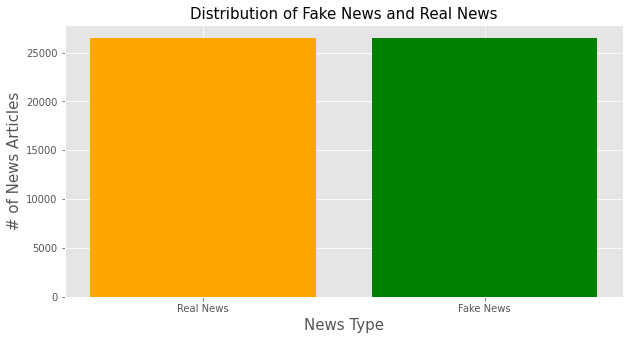

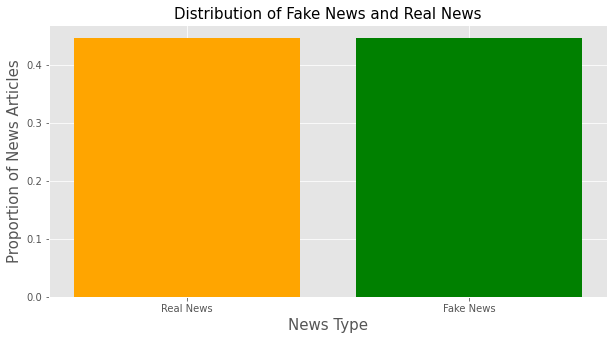

In [77]:
# Plot Fake News / Real News
display_distribution(df_bal)

## Split data for training+validation and testing

In [78]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_bal, test_size=0.30, random_state=27)

Now we can save the training and testting dataset separatly.

In [79]:
df_train.to_csv("fake-news-train.csv")
df_test.to_csv("fake-news-test.csv")

I have downloaded them to my github repo where they can be accessed


```
# This is formatted as code
```



## Loading train dataset only

Datasets can be found at the repo: https://github.com/ZetrextJG/MLProject1_FakeNewsDetection

In [ ]:
!wget https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/fake-news.zip && unzip -d data fake-news.zip

In [16]:
df_train = pd.read_csv("data/fake-news-train.csv", index_col=False)
df_train = df_train.loc[:, ~df_train.columns.str.contains('^Unnamed')]

In [ ]:
df_train.head()

## Data preprocessing - continiuation

In [80]:
X_train = df_train["text"]
y_train = df_train["real"]

Normalization of data:

In [81]:
def normalize(data):
    normalized = []
    j = 0
    for i in data.to_list():
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized


X_train = normalize(X_train)

Converting text to vectors:

In [82]:
max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)

Application of padding (so we have the same length for each article):

In [84]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)

RNN building:

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Creation of early stop, in case that validation no longer improves:

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1113/1113 [==============================] - 111s 91ms/step - loss: 0.3578 - accuracy: 0.8280 - val_loss: 0.1936 - val_accuracy: 0.9310
Epoch 2/10
 444/1113 [==========>...................] - ETA: 28s - loss: 0.1663 - accuracy: 0.9465

Visualize our training over time:

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

## Testing

Loading  test dataset

In [ ]:
df_test = pd.read_csv("data/fake-news-test.csv", index_col=False)
df_test = df_test.loc[:, ~df_test.columns.str.contains('^Unnamed')]

X_test = df_test["text"]
y_test = df_test["real"]

X_test = normalize(X_test)

X_test = tokenizer.texts_to_sequences(X_test)


X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

Evaluation of the testing set:

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Confusion matrix

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax = plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)
plt.show()

Saving weights for visualisation

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

word_index = list(tokenizer.word_index.keys())
word_index = word_index[:max_vocab-1]

Write to file so we can use tensorflow's embedding projector to visualize what our network learned.

In [ ]:
import io

out_v = io.open('PreProcessedData_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('PreProcessedData_meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(word_index):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()